In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_random_directed_graph(num_nodes, edge_probability):
    graph = nx.gnp_random_graph(num_nodes, edge_probability, directed=True)
    return graph

def create_random_undirected_graph(num_nodes, edge_probability):
    graph = nx.gnp_random_graph(num_nodes, edge_probability, directed=False)
    return graph

def draw_graph(graph):
    nx.draw(graph, with_labels=True)
    plt.show()

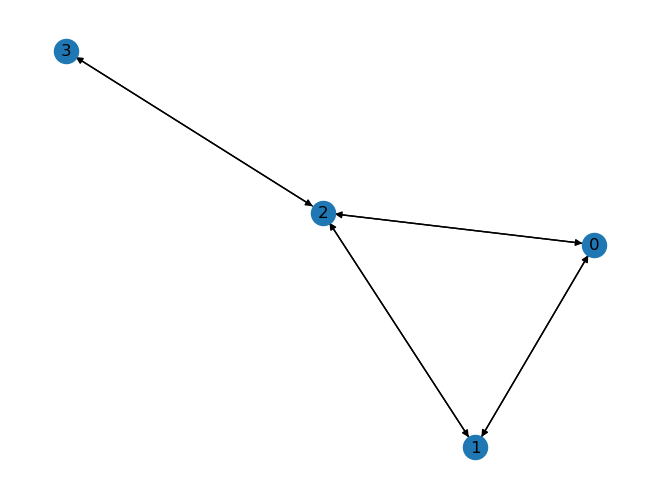

In [47]:
def create_first_graph():
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (2, 0), (2, 1), (2, 3), (3, 2)])
    return G

def create_second_graph():
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2)])
    return G

def create_third_graph():
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 3), (3, 2)])
    return G

G = create_third_graph()
draw_graph(G)

In [4]:
nx.to_latex_raw(G)

'  \\begin{tikzpicture}\n      \\draw\n        (0.0:2) node (0){0}\n        (90.0:2) node (1){1}\n        (180.0:2) node (2){2}\n        (270.0:2) node (3){3};\n      \\begin{scope}[->]\n        \\draw (0) to (1);\n        \\draw (1) to (0);\n        \\draw (1) to (2);\n        \\draw (1) to (3);\n        \\draw (2) to (0);\n        \\draw (2) to (1);\n        \\draw (2) to (3);\n        \\draw (3) to (0);\n        \\draw (3) to (2);\n      \\end{scope}\n    \\end{tikzpicture}\n'

In [33]:
def create_comparator_gate(num_qubits):
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    output = QuantumRegister(1, name="output")

    qc = QuantumCircuit(a, b, output, name="Comparator")
    for i in range(num_qubits):
        qc.cx(a[i], b[i])
    qc.x(b)
    qc.mcx(b, output)
    qc.x(b)
    for i in range(num_qubits-1, -1, -1):
        qc.cx(a[i], b[i])
    
    return qc.to_gate(label="Comparator")

def create_plus_one_gate(num_qubits):
    qr = QuantumRegister(num_qubits, name="q")
    qc = QuantumCircuit(qr, name="PlusOne")

    for i in range(num_qubits-1, 0, -1):
        control_qubits = qr[:i]
        qc.mcx(control_qubits, qr[i])
    qc.x(qr[0])
    return qc.to_gate(label="PlusOne")

def create_minus_one_gate(num_qubits):
    plus_one = create_plus_one_gate(num_qubits)
    minus_one = plus_one.inverse()
    minus_one.label = "MinusOne"
    return minus_one


In [34]:
def initialize_circuit(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")
    output_qr = QuantumRegister(1, name="output")
    classical_reg = ClassicalRegister(num_nodes * qubits_per_node, name="c")

    qc = QuantumCircuit(main_qr, anc_qr, output_qr, classical_reg)

    qc.h(main_qr)
    qc.x(anc_qr)

    return qc, main_qr, anc_qr, output_qr, classical_reg

def create_missing_edge_block(G, comparator, plus_one, minus_one, num_nodes, qubits_per_node):
    def get_missing_edges(G):
        complement = nx.complement(G.to_directed())
        missing_edges = list(complement.edges())
        double_edges = []
        for edge in missing_edges:
            if (edge[1], edge[0]) in missing_edges:
                missing_edges.remove((edge[1], edge[0]))
                missing_edges.remove(edge)
                double_edges.append(edge)
                print(f"Removed {edge}")
        return missing_edges, double_edges
    
    missing_edges, double_edges = get_missing_edges(G)
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")

    qc = QuantumCircuit(main_qr, anc_qr)

    counter = 0
    for edge in missing_edges:
        print(edge)
        target_1 = list(range(edge[0]*qubits_per_node, (edge[0]+1)*qubits_per_node))
        target_2 = list(range(edge[1]*qubits_per_node, (edge[1]+1)*qubits_per_node))
        qc.append(plus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(minus_one, target_1)
        counter += 1
    

    for edge in double_edges:
        print(edge)
        target_1 = list(range(edge[0]*qubits_per_node, (edge[0]+1)*qubits_per_node))
        target_2 = list(range(edge[1]*qubits_per_node, (edge[1]+1)*qubits_per_node))
        qc.append(plus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(minus_one, target_1)
        qc.append(minus_one, target_1)
        qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
        qc.append(plus_one, target_1)

        counter += 1

    missing_gate = qc.to_gate(label="MissingEdgeBlock")
    return missing_gate

def create_positional_exclusivity_block(G, comparator, num_nodes, qubits_per_node):
    aux_qubits = num_nodes * (num_nodes-1)/2

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(aux_qubits, name="anc")

    qc = QuantumCircuit(main_qr, anc_qr)

    counter = 0
    for i in range(num_nodes):
        target_1 = list(range(i*qubits_per_node, (i+1)*qubits_per_node))
        for j in range(i+1, num_nodes):
            target_2 = list(range(j*qubits_per_node, (j+1)*qubits_per_node))
            qc.append(comparator, target_1 + target_2 + [anc_qr[counter]])
            counter += 1

    exclusivity_gate = qc.to_gate(label="PositionalExclusivityBlock")
    return exclusivity_gate


In [35]:
def create_oracle(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
    
    # Create the gates for the blocks
    comparator = create_comparator_gate(qubits_per_node)
    plus_one = create_plus_one_gate(qubits_per_node)
    minus_one = create_minus_one_gate(qubits_per_node)

    
    # Create the blocks
    missing_edge_block = create_missing_edge_block(G, comparator, plus_one, minus_one, num_nodes, qubits_per_node)
    positional_exclusivity_block = create_positional_exclusivity_block(G, comparator, num_nodes, qubits_per_node)

    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    anc_qr = QuantumRegister(num_nodes * (num_nodes-1)/2, name="anc")
    output_qr = QuantumRegister(1, name="output")
    qc = QuantumCircuit(main_qr, anc_qr, output_qr)

    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])
    qc.mcx(anc_qr, output_qr)
    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])

    qc.append(positional_exclusivity_block, main_qr[:] + anc_qr[:])
    qc.h(output_qr)
    qc.mcx(anc_qr, output_qr)
    qc.h(output_qr)
    qc.append(positional_exclusivity_block, main_qr[:] + anc_qr[:])

    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])
    qc.mcx(anc_qr, output_qr)
    qc.append(missing_edge_block, main_qr[:] + anc_qr[:])

    oracle = qc.to_gate(label="Oracle")
    return oracle

def create_grover_diffusion_operator(G):
    num_nodes = G.number_of_nodes()
    qubits_per_node = int(np.ceil(np.log2(num_nodes)))
                          
    main_qr = QuantumRegister(num_nodes * qubits_per_node, name="main")
    qc = QuantumCircuit(main_qr)
    qc.h(main_qr)
    qc.x(main_qr)
    qc.h(main_qr[-1])
    qc.mcx(main_qr[:-1], main_qr[-1])
    qc.h(main_qr[-1])
    qc.x(main_qr)
    qc.h(main_qr)

    diffusion_operator = qc.to_gate(label="DiffusionOperator")
    return diffusion_operator

def build_circuit(G, iterations=1):
    qc, main_qr, anc_qr, output_qr, classical_reg = initialize_circuit(G)
    oracle = create_oracle(G)
    diffuser = create_grover_diffusion_operator(G)

    for _ in range(iterations):
        qc.append(oracle, main_qr[:] + anc_qr[:] + output_qr[:])
        qc.append(diffuser, main_qr[:])
    qc.measure(main_qr, classical_reg)

    return qc


In [49]:

circuit = build_circuit(G, 1)
# circuit.decompose().decompose().draw(output="mpl")
# circuit.decompose().draw(output="mpl")
# circuit.draw(output="mpl")


Removed (0, 3)
Removed (3, 1)
(0, 3)
(3, 1)


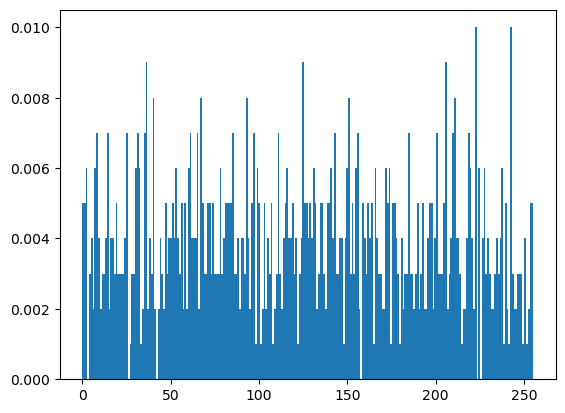

In [50]:

sampler = Sampler()
result = sampler.run(circuit, shots=1000).result()
data = result.quasi_dists[0]
plt.hist(data.keys(), weights=data.values(), bins=256)
plt.show()


In [51]:
# convert the data to binary, maintaining the dictionary structure
binary_data = {format(k, '08b'): v for k, v in data.items()}

# Get the onnes with a more than 1% probability
filtered_data = {k: v for k, v in binary_data.items() if v > 0.015}
print(filtered_data)
# Separe each result into four two bit strings, and convert them to integers
results = {tuple([int(k[i:i+2], 2) for i in range(0, 8, 2)]): v for k, v in filtered_data.items()}
for r in results:
    print(r, results[r])



{}


In [ ]:
draw_graph(G)